# Understanding Crime in Chicago
An Exploratory Data Analysis (EDA) and Visualization for Crime in Chicago from 2005 to 2017<br/>
Bhushan Pagare

----

In this notebook, I will explore crimes in Chicago from a perspective of Chicago resident who wants to know more about the subject so he can better navigate his way through the city

So, before starting off with the analysis, Let me brief you about the dataset, According to the briefings, it says:

> This dataset reflects reported incidents of crime (with the exception of murders where data exists for each victim) that occurred in the City of Chicago from 2001 to present, minus the most recent seven days. Data is extracted from the Chicago Police Department’s CLEAR (Citizen Law Enforcement Analysis and Reporting) system. In order to protect the privacy of crime victims, addresses are shown at the block level only and specific locations are not identified.

### Little Introduction and Motivation
**Crime in Chicago** is a very interesting topic for exploration for all kinds of reason. It has been always the topic of conversation among the residents of Chicago. Another important reason is the availability of huge amounts of publicly available high quality crime dataset open for Data Scientist to mine and investigate.

In this notebook, I am going to explore more about Crime in Chicago and try to answer few questions:
- How has crime in Chicago changed across years ? Was 2016 really [the bloodiest year in two decades](https://www.newsweek.com/2016/12/23/chicago-gangs-violence-murder-rate-532034.html)?
- Are some type of crime more likely to happen in specific locations or specific time of the day or specific day of week than other types of crimes ?
- What will be the safest place for me in Chicago ?

First, we import the required data science packages and get the [data](https://www.kaggle.com/currie32/crimes-in-chicago/data)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import seaborn as sns
plt.style.use('seaborn')

crimes1 = pd.read_csv('Chicago_Crimes_2005_to_2007.csv',error_bad_lines=False)
crimes2 = pd.read_csv('Chicago_Crimes_2008_to_2011.csv',error_bad_lines=False)
crimes3 = pd.read_csv('Chicago_Crimes_2012_to_2017.csv',error_bad_lines=False)
# Concating the above 4 datasets together
crimes = pd.concat([crimes1, crimes2, crimes3], ignore_index=False, axis=0)

del crimes1
del crimes2
del crimes3

print('Dataset ready ...')

print('Dataset Shape before drop_duplicate : ', crimes.shape)
crimes.drop_duplicates(subset=['ID', 'Case Number'], inplace=True)
print('Dataset Shape after drop_duplicate: ', crimes.shape)

b'Skipping line 533719: expected 23 fields, saw 24\n'
b'Skipping line 1149094: expected 23 fields, saw 41\n'


Dataset ready ...
Dataset Shape before drop_duplicate :  (6017767, 23)
Dataset Shape after drop_duplicate:  (4336556, 23)


We will not be using all the columns in our analysis, so we will filter them out

In [2]:
crimes = crimes[['ID', 'Date', 'Block', 'Primary Type', 'Description', 'Location',
                 'Location Description', 'Arrest', 'Domestic', 'Latitude', 'Longitude']]

As we can tell from the first few rows, we have several columns that will help us answer our questions. We will use the 'Date' column to explore temporal patterns, 'Primary Type' and 'Location Description' to investigate their relationship with time (month of the year, time of the day, hour of the day, .. etc). Later we will use geolocation to map out safe spots (and times) in the city.

In [3]:
#Let's have a look at the first 3 records and see if we see what we expect
crimes.head(3)

ID                    Date               Block   Primary Type  \
0  4673626  04/02/2006 01:00:00 PM   055XX N MANGO AVE  OTHER OFFENSE   
1  4673627  02/26/2006 01:40:48 PM  065XX S RHODES AVE      NARCOTICS   
2  4673628  01/08/2006 11:16:00 PM     013XX E 69TH ST        ASSAULT   

               Description                       Location  \
0  HARASSMENT BY TELEPHONE  (41.981912692, -87.771996382)   
1       MANU/DELIVER:CRACK  (41.775732538, -87.611919814)   
2      AGGRAVATED: HANDGUN  (41.769897392, -87.593670899)   

  Location Description  Arrest  Domestic   Latitude  Longitude  
0            RESIDENCE   False     False  41.981913 -87.771996  
1             SIDEWALK    True     False  41.775733 -87.611920  
2                OTHER   False     False  41.769897 -87.593671

The very first step maybe to check if dataset contains any null values or not, and droping them out of dataset

In [4]:
print('Dataset Shape before dropping null values : ', crimes.shape)
crimes.dropna(inplace=True)
print('Dataset Shape after dropping null values: ', crimes.shape)

Dataset Shape before dropping null values :  (4336556, 11)
Dataset Shape after dropping null values:  (4274886, 11)


Great !! Because we are dealing with dates, we need to convert the 'Date' column into a date format that is understandable by Python (and pandas).

In [5]:
# Converting dates into pandas datetime format
crimes.Date = pd.to_datetime(crimes.Date, format='%m/%d/%Y %I:%M:%S %p')
# Setting the index to be the date that will help us a lot
crimes.index = pd.DatetimeIndex(crimes.Date)

In [6]:
# Lets take a look at dataset again to see the changes
crimes.head(3)

ID                Date               Block  \
Date                                                                   
2006-04-02 13:00:00  4673626 2006-04-02 13:00:00   055XX N MANGO AVE   
2006-02-26 13:40:48  4673627 2006-02-26 13:40:48  065XX S RHODES AVE   
2006-01-08 23:16:00  4673628 2006-01-08 23:16:00     013XX E 69TH ST   

                      Primary Type              Description  \
Date                                                          
2006-04-02 13:00:00  OTHER OFFENSE  HARASSMENT BY TELEPHONE   
2006-02-26 13:40:48      NARCOTICS       MANU/DELIVER:CRACK   
2006-01-08 23:16:00        ASSAULT      AGGRAVATED: HANDGUN   

                                          Location Location Description  \
Date                                                                      
2006-04-02 13:00:00  (41.981912692, -87.771996382)            RESIDENCE   
2006-02-26 13:40:48  (41.775732538, -87.611919814)             SIDEWALK   
2006-01-08 23:16:00  (41.769897392, -87.593670899)                OTHER   

                     Arrest  Domestic   Latitude  Longitude  
Date                                                         
2006-04-02 13:00:00   False     False  41.981913 -87.771996  
2006-02-26 13:40:48    True     False  41.775733 -87.611920  
2006-01-08 23:16:00   False     False  41.769897 -87.593671

Let's make sure we are dealing with the right types of columns

In [7]:
crimes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4274886 entries, 2006-04-02 13:00:00 to 2016-05-03 23:38:00
Data columns (total 11 columns):
ID                      int64
Date                    datetime64[ns]
Block                   object
Primary Type            object
Description             object
Location                object
Location Description    object
Arrest                  bool
Domestic                bool
Latitude                float64
Longitude               float64
dtypes: bool(2), datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 334.3+ MB



As 'Location Description', 'Description' and 'Primary Type' columns are actually categorical columns (or factors in R), we will only keep the most frequent categories and then cast them to a categorical type.

In [8]:
loc_to_change  = list(crimes['Location Description'].value_counts()[20:].index)
desc_to_change = list(crimes['Description'].value_counts()[20:].index)
#type_to_change = list(crimes['Primary Type'].value_counts()[20:].index)

crimes.loc[crimes['Location Description'].isin(loc_to_change) , crimes.columns=='Location Description'] = 'OTHER'
crimes.loc[crimes['Description'].isin(desc_to_change) , crimes.columns=='Description'] = 'OTHER'
#crimes.loc[crimes['Primary Type'].isin(type_to_change) , crimes.columns=='Primary Type'] = 'OTHER'

In [9]:
# we convert those 3 columns into 'Categorical' types -- works like 'factor' in R
crimes['Primary Type']         = pd.Categorical(crimes['Primary Type'])
crimes['Location Description'] = pd.Categorical(crimes['Location Description'])
crimes['Description']          = pd.Categorical(crimes['Description'])

In [10]:
# Let's take the look at final dataset
crimes.head(3)

ID                Date               Block  \
Date                                                                   
2006-04-02 13:00:00  4673626 2006-04-02 13:00:00   055XX N MANGO AVE   
2006-02-26 13:40:48  4673627 2006-02-26 13:40:48  065XX S RHODES AVE   
2006-01-08 23:16:00  4673628 2006-01-08 23:16:00     013XX E 69TH ST   

                      Primary Type              Description  \
Date                                                          
2006-04-02 13:00:00  OTHER OFFENSE  HARASSMENT BY TELEPHONE   
2006-02-26 13:40:48      NARCOTICS                    OTHER   
2006-01-08 23:16:00        ASSAULT                    OTHER   

                                          Location Location Description  \
Date                                                                      
2006-04-02 13:00:00  (41.981912692, -87.771996382)            RESIDENCE   
2006-02-26 13:40:48  (41.775732538, -87.611919814)             SIDEWALK   
2006-01-08 23:16:00  (41.769897392, -87.593670899)                OTHER   

                     Arrest  Domestic   Latitude  Longitude  
Date                                                         
2006-04-02 13:00:00   False     False  41.981913 -87.771996  
2006-02-26 13:40:48    True     False  41.775733 -87.611920  
2006-01-08 23:16:00   False     False  41.769897 -87.593671

I think at this point we are pretty much ready to explore

### Data Exploration and Data Visualization
At this point, I think we are done with all the preprocessing and cleaning. Now it is time to see what we got. In this section, I will make use of many of pandas functionality like resampling by a time frame and pivot_table (a function that somehow changes the way I think!).

Let us begin by some generic queries, like how many records we have for each month? 

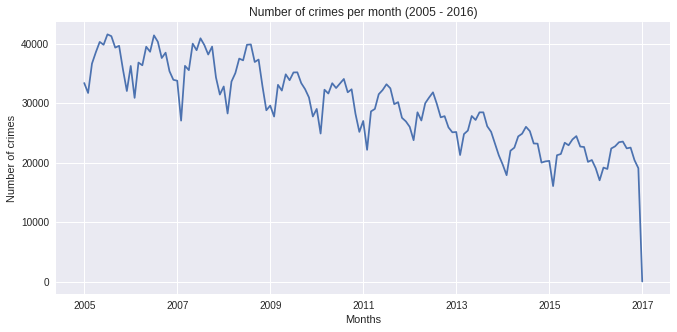

In [11]:
plt.figure(figsize=(11,5))
crimes.resample('M').size().plot(legend=False)
plt.title('Number of crimes per month (2005 - 2016)')
plt.xlabel('Months')
plt.ylabel('Number of crimes')
plt.show()

This chart shows a clear "periodic" pattern in the crimes over many years. I guess this very periodic pattern is an issential part of why crime a very predictable activity

Before we take a deeper look into how other features could mediate such temporal consistency, I first want to answer our first question: **How crime has changed over the years? is it decreasing?** Let's have a look at what we have (from 2012 to 2016 for now).

In a previous chart, we already looked at the number of weekly crime records. Although it may not be very clear from the previous chart how crime have changed over the years, it still gives somehow similar numbers between 2015 and 2016. Here, we will take a finer scale to get the visualization right. I decided to look at the rolling sum of crimes of the past year. The idea is, for each day, we calculate the sum of crimes of the past year. If this rolling sum is decreasing, then we know for sure that crime rates have been decreasing during that year. On the other hand, if the rolling sum stays the same during a given year, then we can conclude that crime rates stayed the same.

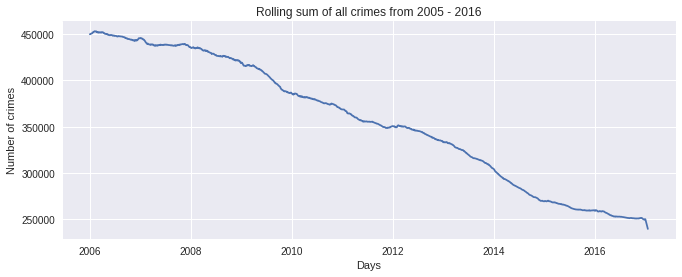

In [12]:
plt.figure(figsize=(11,4))
crimes.resample('D').size().rolling(365).sum().plot()
plt.title('Rolling sum of all crimes from 2005 - 2016')
plt.ylabel('Number of crimes')
plt.xlabel('Days')
plt.show()

We see the line decreasing from 2006 up to some point around 2016 after which it stays around the same number of crimes. This all means that 2016 is really no better than 2015, but both years show a much better crime record (in total) than the previous years.

But... could this figure be too good to be true?

Let's seperate crimes by type and see

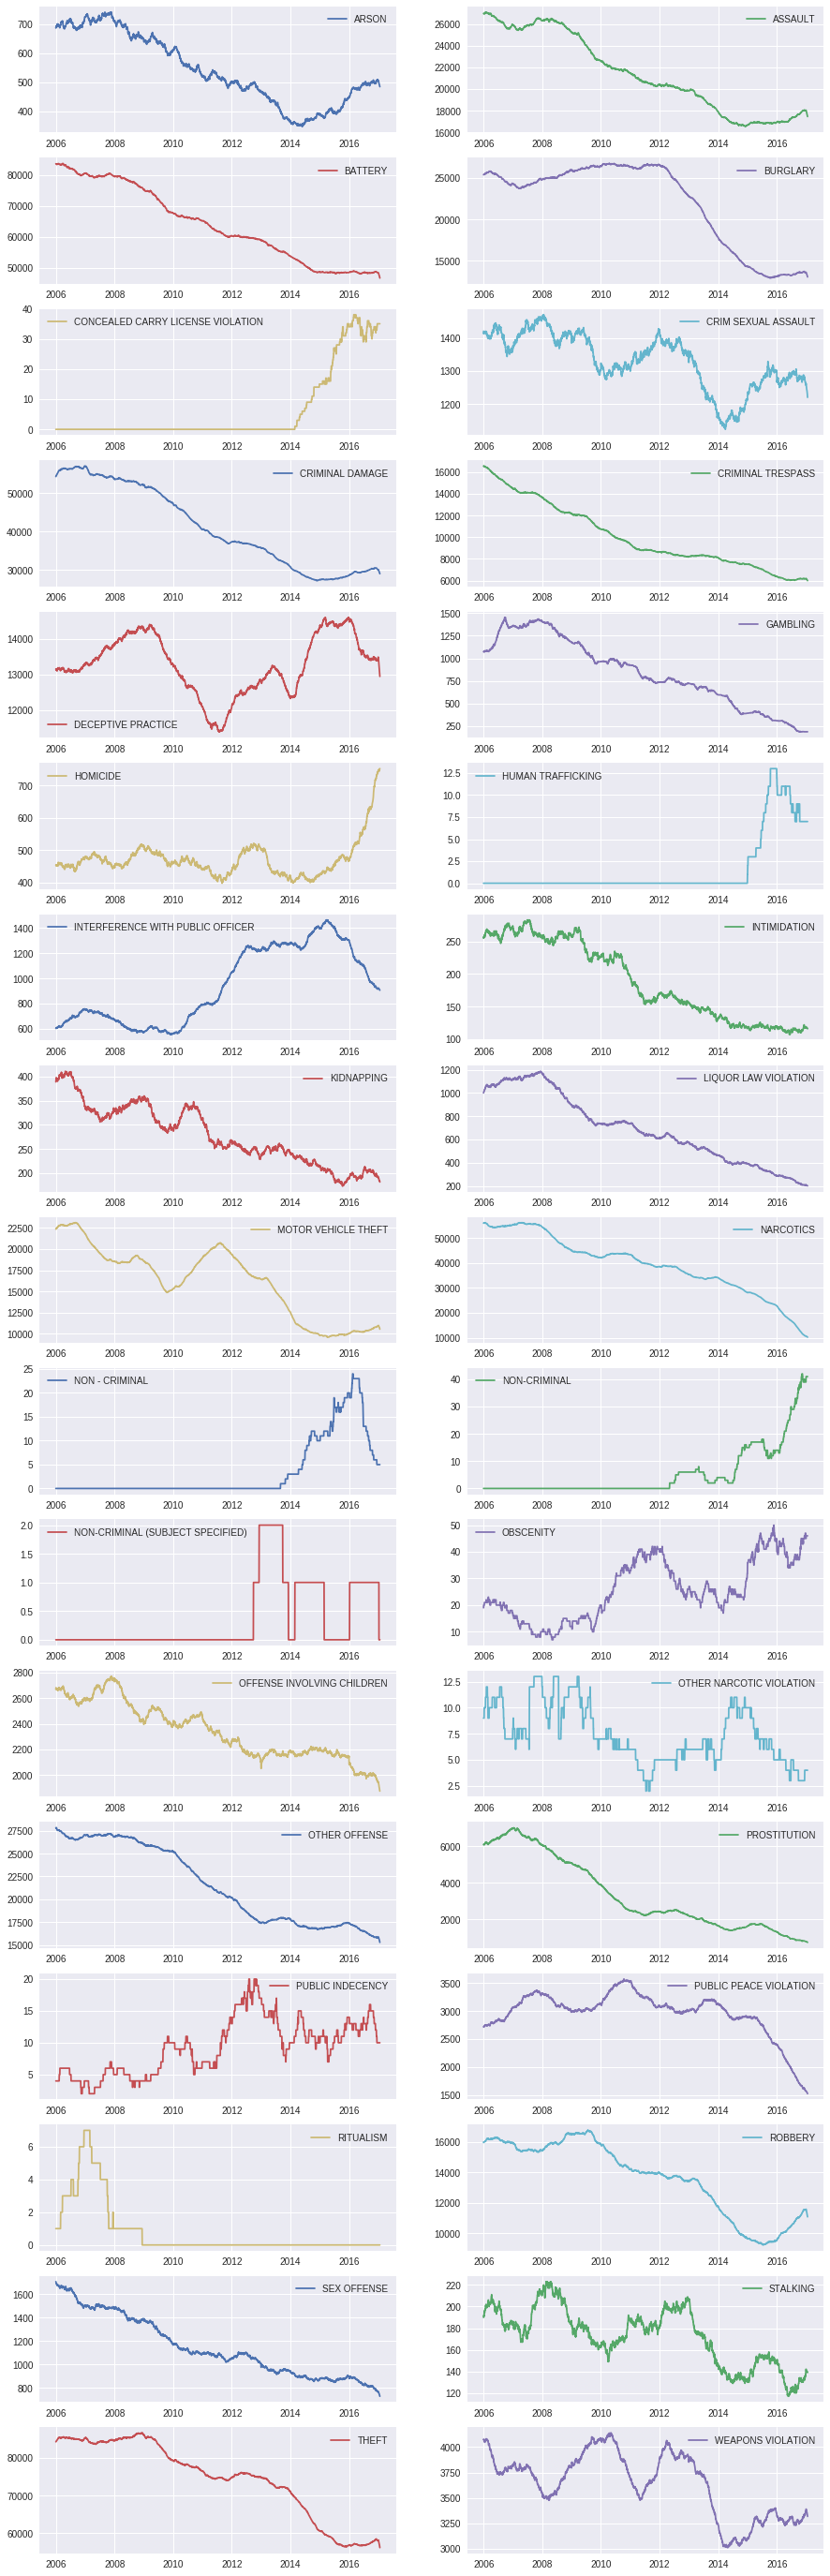

In [13]:
crimes_count_date = crimes.pivot_table('ID', aggfunc=np.size, columns='Primary Type', index=crimes.index.date, fill_value=0)
crimes_count_date.index = pd.DatetimeIndex(crimes_count_date.index)
plot = crimes_count_date.rolling(365).sum().plot(figsize=(15, 50), subplots=True, layout=(-1, 2), sharex=False, sharey=False)

Hmmm. Lots of things can be said. I have stared at this plot myself for long because I was really excited to see the first figure and hoped it reflected an average trend toward decreasing crimes. But it is not the case. Some crime types are actually increasing all along like homicide and deceptive practice. Other types started to increase slightly before 2016 like theft, robbery and stalking (which may be the reason behind the trend we saw earlier).

### A general view of crime records by time, type and location

Not all crimes are the same. Some crimes types are more likely to occur than other types depending on the place and time. In this section, we will see how crimes differ between different places at different times.

The first thing we are going to look at is if there is a difference in the number of crimes during specific days of the week. Are there more crimes during weekdays or weekend?

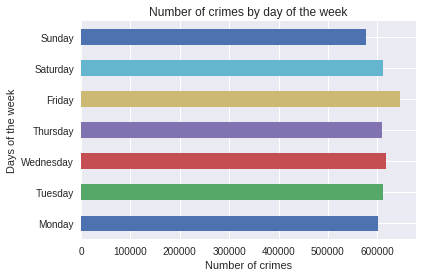

In [14]:
days = ['Monday','Tuesday','Wednesday',  'Thursday', 'Friday', 'Saturday', 'Sunday']
crimes.groupby([crimes.index.dayofweek]).size().plot(kind='barh')
plt.ylabel('Days of the week')
plt.yticks(np.arange(7), days)
plt.xlabel('Number of crimes')
plt.title('Number of crimes by day of the week')
plt.show()

I don't really see something is different between days of the week. Maybe Friday has higher number of crime than other days, but this is still based on the counts and we are not really sure of it means it is always like this.

Now Let's look at crimes per month and see if certain months show more crimes than others.

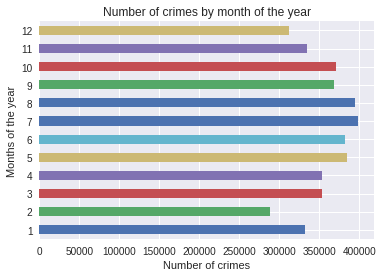

In [15]:
crimes.groupby([crimes.index.month]).size().plot(kind='barh')
plt.ylabel('Months of the year')
plt.xlabel('Number of crimes')
plt.title('Number of crimes by month of the year')
plt.show()

It is pretty clear that crimes are seem to peak in summer

Let's have a look at the distribution of crime by their types, which crimes are most common among the top 20 most frequent crime types ?

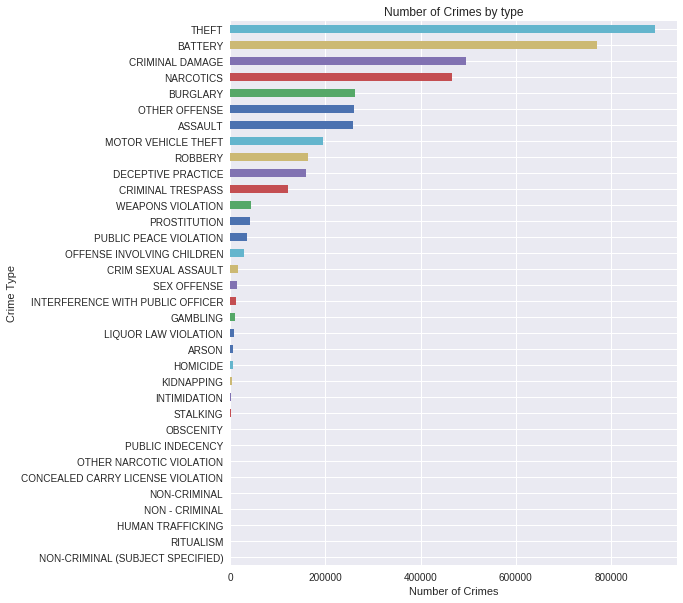

In [16]:
plt.figure(figsize=(8, 10))
crimes.groupby([crimes['Primary Type']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of Crimes by type')
plt.ylabel('Crime Type')
plt.xlabel('Number of Crimes')
plt.show()

Similarly by Crime locations

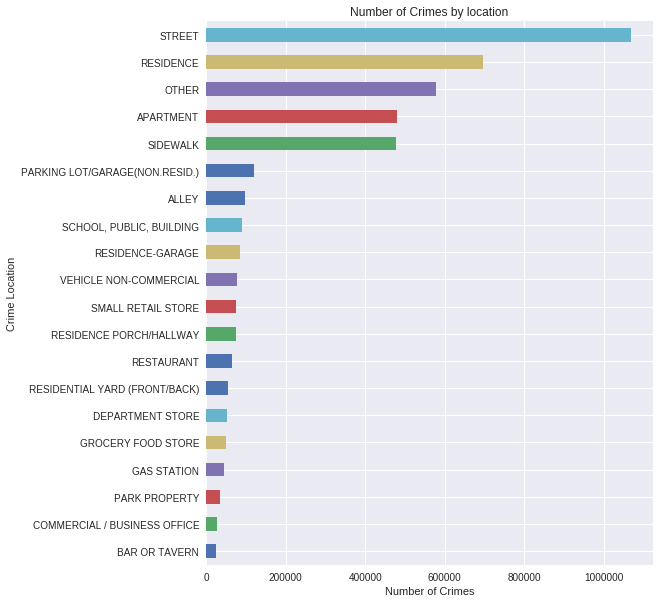

In [17]:
plt.figure(figsize=(8, 10))
crimes.groupby([crimes['Location Description']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of Crimes by location')
plt.ylabel('Crime Location')
plt.xlabel('Number of Crimes')
plt.show()

### Temporal analysis of crime rates by type and location

I am not so excited by the charts so far. They are boring. They do not show me interesting things. It only felt like they make sense. In this section, things are way different. We will directly address the second question in the introduction.

Not all crimes are the same. Some crimes types are more likely to occur than other types depending on the place and time. In this section, we will see how crimes differ between different places at different times.

After seeing the base rates of each crime location and type, we will now assume that all crime types (and locations) have the same frequency or, in other words, they are all equal overall. We are interested in detecting how a specific crime type is different across all days of the week or hours of the day.

Is theft or burglary is more likely to occur at a weekday compared to a weekend? Are they more likely to happen in the morning vs evening or late night ? are they more likely to occur in a street vs a bar?

Let's dig up using the fantastic 'pivot_table' from pandas.

In [18]:
hour_by_location = crimes.pivot_table(values='ID', index='Location Description', columns=crimes.index.hour, aggfunc=np.size).fillna(0)
hour_by_type     = crimes.pivot_table(values='ID', index='Primary Type', columns=crimes.index.hour, aggfunc=np.size).fillna(0)
hour_by_week     = crimes.pivot_table(values='ID', index=crimes.index.hour, columns=crimes.index.weekday_name, aggfunc=np.size).fillna(0)
hour_by_week     = hour_by_week[days].T # just reorder columns according to the the order of days
dayofweek_by_location = crimes.pivot_table(values='ID', index='Location Description', columns=crimes.index.dayofweek, aggfunc=np.size).fillna(0)
dayofweek_by_type = crimes.pivot_table(values='ID', index='Primary Type', columns=crimes.index.dayofweek, aggfunc=np.size).fillna(0)
location_by_type  = crimes.pivot_table(values='ID', index='Location Description', columns='Primary Type', aggfunc=np.size).fillna(0)

Here I will make nice wrapper functions to make some minimal preprocessing and make the heatmap visualization. A trick I used to make heatmaps nicer looking is to use a clustering algorithm to sort the rows into meaningful groups and use group labels to re-sort our matrix.

In [19]:
from sklearn.cluster import AgglomerativeClustering as AC

def scale_df(df,axis=0):
    '''
    A utility function to scale numerical values (z-scale) to have a mean of zero
    and a unit variance.
    '''
    return (df - df.mean(axis=axis)) / df.std(axis=axis)

def plot_hmap(df, ix=None, cmap='bwr'):
    '''
    A function to plot heatmaps that show temporal patterns
    '''
    if ix is None:
        ix = np.arange(df.shape[0])
    plt.imshow(df.iloc[ix,:], cmap=cmap)
    plt.colorbar(fraction=0.03)
    plt.yticks(np.arange(df.shape[0]), df.index[ix])
    plt.xticks(np.arange(df.shape[1]))
    plt.grid(False)
    plt.show()
    
def scale_and_plot(df, ix = None):
    '''
    A wrapper function to calculate the scaled values within each row of df and plot_hmap
    '''
    df_marginal_scaled = scale_df(df.T).T
    if ix is None:
        ix = AC(4).fit(df_marginal_scaled).labels_.argsort() # a trick to make better heatmaps
    cap = np.min([np.max(df_marginal_scaled.as_matrix()), np.abs(np.min(df_marginal_scaled.as_matrix()))])
    df_marginal_scaled = np.clip(df_marginal_scaled, -1*cap, cap)
    plot_hmap(df_marginal_scaled, ix=ix)

def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

Before we go on, let me explain how we got those heatmaps. For each set of those pots, I re-scaled counts of crime records in each hour within each crime type to be z-scaled (to have a mean of zero and a unit standard deviation). So it is a "within-type/ across-hours" scaling that aims to show differences between frequencies of crimes at different hours. All types have the save "average" of crime counts, but not all hours have the same average. So a negative value indicate a lower frequency while a positive value indicate a higher frequency for that crime to occur in a particular hour.

First, let's see if there are "day crimes vs night crimes" thing. As you can see, some crimes have their peaks during the early morning (upper part of the heatmap), other crimes peak during the day (mid-part of the heatmap) and the final group of crimes peak at night (lower part of the heatmap)

/home/bhushan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


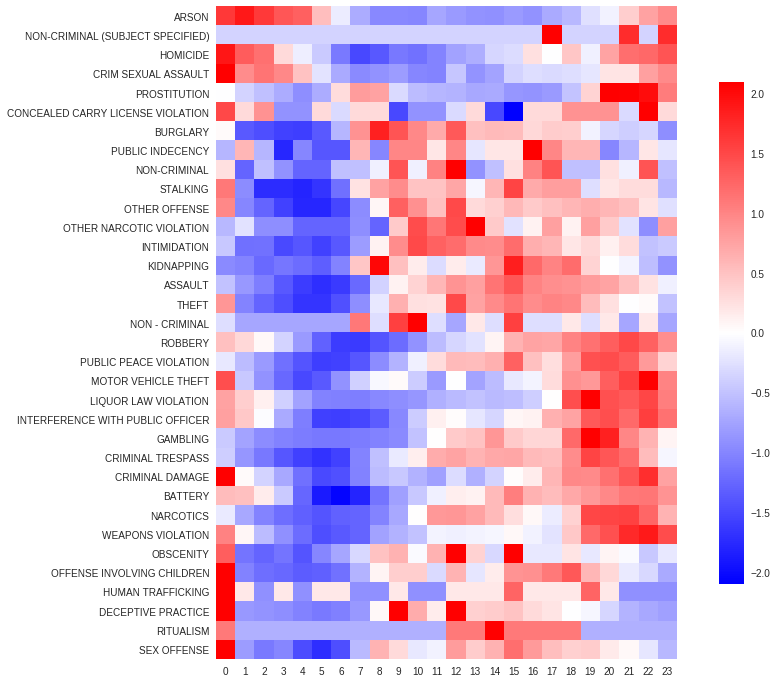

In [20]:
plt.figure(figsize=(15,12))
scale_and_plot(hour_by_type)

Similarly, we will look at crime locations and see some locations are more likely to have crimes during the day vs. during the night. The upper part of the heatmap shows locations that have crime peaks during the day (with a couple of them peaking at 9AM). The mid-part shows locations that have crime peaks during the night ad finally the lower part (a single observation) shows that bars have crime peaks during early morning.

/home/bhushan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


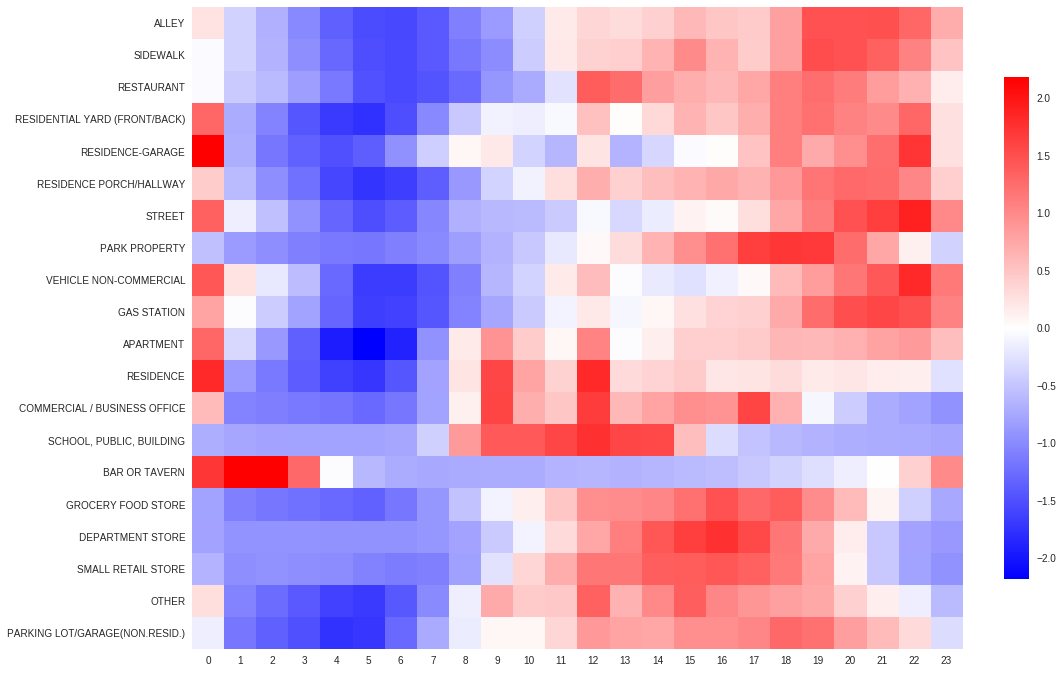

In [21]:
plt.figure(figsize=(15,12))
scale_and_plot(hour_by_location)

But is this 'day crimes vs. night crimes" thing consistent during all days of the week? I mean, can't we expect weekends to show a different pattern in the timing of crimes? Sure they do.

/home/bhushan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


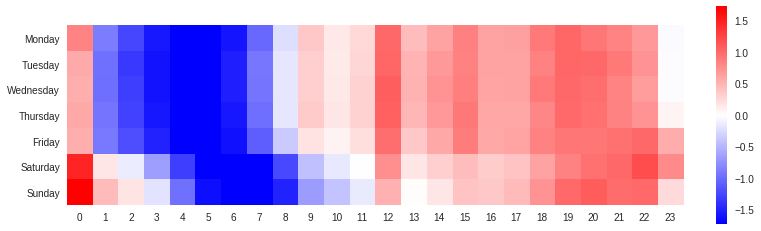

In [22]:
plt.figure(figsize=(12,4))
scale_and_plot(hour_by_week, ix=np.arange(7))

I am excited to see more about this "weekday crime vs. weekend crime" thing. So let's dig deeper and see of they have anything with crime types.

The heatmap below indicates few interesting things (x-axis is days of the week). Some crimes types peak at specific days of the week (like Friday or Saturday). Other types are more like weekday crimes (showing in the mid-part of the heatmap) or weekend crimes (showing in the lower part of the heatmap).

/home/bhushan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


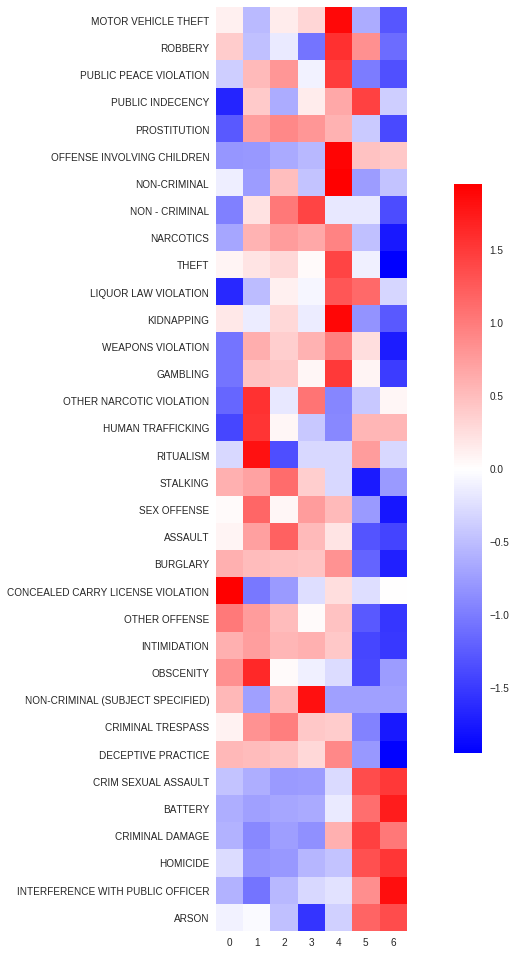

In [23]:
plt.figure(figsize=(17,17))
scale_and_plot(dayofweek_by_type)

### Where a certain crime type is most likely to happen?

In this section, we hope to answer another type of questions: for a given crime (like theft or sexual assault), what is the most likely location for this crime to happen? In this analysis, as with the previous ones, we take each crime type and re-normalize its location frequency to be between zero and one. This way, we can look at the top frequent locations of each crime type (darker red reflect a more frequent location).

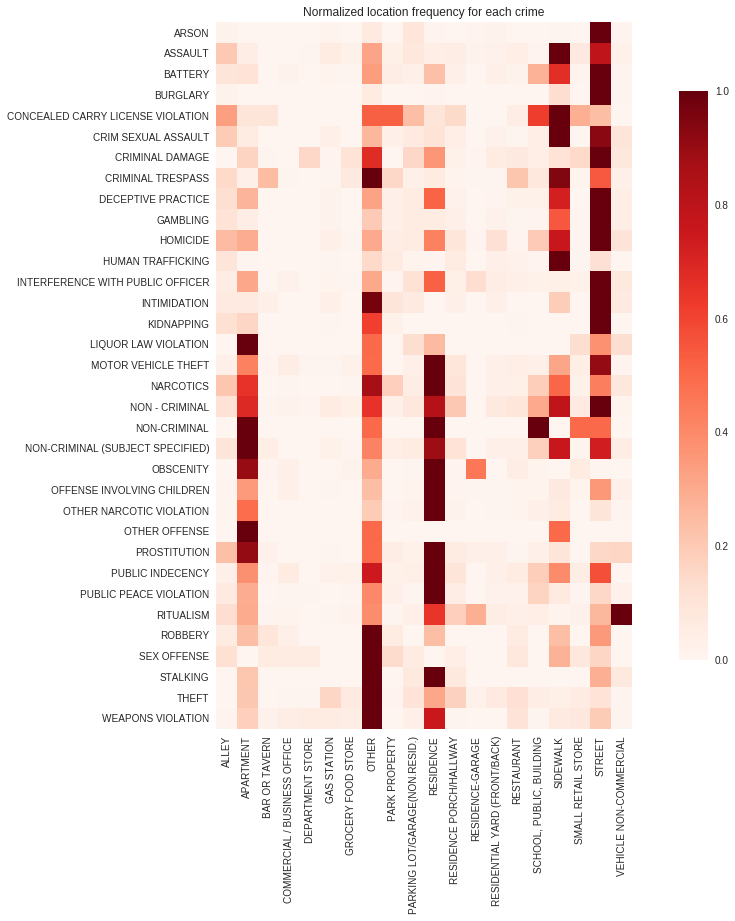

In [24]:
df = normalize(location_by_type)
ix = AC(3).fit(df.T).labels_.argsort() # a trick to make better heatmaps
plt.figure(figsize=(17,13))
plt.imshow(df.T.iloc[ix,:], cmap='Reds')
plt.colorbar(fraction=0.03)
plt.xticks(np.arange(df.shape[0]), df.index, rotation='vertical')
plt.yticks(np.arange(df.shape[1]), df.columns)
plt.title('Normalized location frequency for each crime')
plt.grid(False)
plt.show()

Well, it appears that most crimes occur at either apartments, residence, sidewalks, streets or 'other'. There are few notable exceptions here and there but those places are very frequent.

Now let's take a closer look at geolocation data available and find out safe/unsafe spots

In [25]:
def Location_extractor(Raw_Str):
    preProcess = Raw_Str[1:-1].split(',')
    lat =  float(preProcess[0])
    long = float(preProcess[1])
    return (lat, long)

In [26]:
unique_locations = crimes['Location'].value_counts()

crime_index = pd.DataFrame({"Raw_String" : unique_locations.index, "ValueCount":unique_locations})
crime_index.index = range(len(unique_locations))
crime_index.head()

Raw_String  ValueCount
0  (41.976290414, -87.905227221)        8376
1  (41.754592961, -87.741528537)        6215
2  (41.883500187, -87.627876698)        4714
3  (41.897895128, -87.624096605)        2960
4  (41.909664252, -87.742728815)        2665

In [27]:
crime_index['LocationCoord'] = crime_index['Raw_String'].apply(Location_extractor)
crime_index  = crime_index.drop(columns=['Raw_String'], axis = 1)
print(crime_index.shape[0])

573927


In [28]:
chicago_map_crime = folium.Map(location=[41.895140898, -87.624255632],
                        zoom_start=14,
                        tiles="CartoDB dark_matter")

for i in range(1000):
    lat = crime_index['LocationCoord'].iloc[i][0]
    long = crime_index['LocationCoord'].iloc[i][1]
    radius = crime_index['ValueCount'].iloc[i] / 45
    
    if crime_index['ValueCount'].iloc[i] > 2000:
        color = "#FF4500"
    else:
        color = "#008080"
    
    popup_text = """Latitude : {}<br>
                Longitude : {}<br>
                Criminal Incidents : {}<br>"""
    popup_text = popup_text.format(lat,
                               long,
                               crime_index['ValueCount'].iloc[i]
                               )
    folium.CircleMarker(location = [lat, long], popup= popup_text,radius = radius, color = color, fill = True).add_to(chicago_map_crime)
    
chicago_map_crime

From map it is possible to see safe locations around Chicago

## Conclusion

We believe this data analytic project give us a scientific view about the security status and crime rate of the Chicago city. According to the analysis result and visualization, we can view the most frequently occurring crimes and the frequent occurring locations where crimes happened. From these reports, the most occurred crimes were theft, battery, criminal damage and narcotics which is 65.7% of all the crimes reported. The most common locations to occur the crimes are at street, sidewalks, residence, an apartment which are where people are mostly at. We specifically looked into certain crime types to view how they have changed over the years, such as theft, homicide, and sexual crimes. Even though there were a lot of reported crimes in Chicago each year, the arrest rate was not even as high as 50% for each year letting us believe that Chicago’s police arrest or investigation methods were not effective enough. We believe if our data analytics can give us all these information about the security status of the Chicago city, a bigger data analytics project will provide much more valuable information which can be used as a powerful source for taking wise actions that increases the security status of our cities.